In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.utils_correspondence import resize
from model_utils.extractor_sd import load_model, process_features_and_mask
from model_utils.extractor_dino import ViTExtractor
from model_utils.projection_network import AggregationNetwork
from preprocess_map import set_seed

set_seed(42)
num_patches = 60
sd_model = sd_aug = extractor_vit = None
aggre_net = AggregationNetwork(feature_dims=[640,1280,1280,768], projection_dim=768, device='cuda')
aggre_net.load_pretrained_weights(torch.load('results_spair/best_856.PTH'))
        
def get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=None, img_path=None):
    
    if img_path is not None:
        feature_base = img_path.replace('JPEGImages', 'features').replace('.jpg', '')
        sd_path = f"{feature_base}_sd.pt"
        dino_path = f"{feature_base}_dino.pt"

    # extract stable diffusion features
    if img_path is not None and os.path.exists(sd_path):
        features_sd = torch.load(sd_path)
        for k in features_sd:
            features_sd[k] = features_sd[k].to('cuda')
    else:
        if img is None: img = Image.open(img_path).convert('RGB')
        img_sd_input = resize(img, target_res=num_patches*16, resize=True, to_pil=True)
        features_sd = process_features_and_mask(sd_model, sd_aug, img_sd_input, mask=False, raw=True)
        del features_sd['s2']

    # extract dinov2 features
    if img_path is not None and os.path.exists(dino_path):
        features_dino = torch.load(dino_path)
    else:
        if img is None: img = Image.open(img_path).convert('RGB')
        img_dino_input = resize(img, target_res=num_patches*14, resize=True, to_pil=True)
        img_batch = extractor_vit.preprocess_pil(img_dino_input)
        features_dino = extractor_vit.extract_descriptors(img_batch.cuda(), layer=11, facet='token').permute(0, 1, 3, 2).reshape(1, -1, num_patches, num_patches)

    desc_gathered = torch.cat([
            features_sd['s3'],
            F.interpolate(features_sd['s4'], size=(num_patches, num_patches), mode='bilinear', align_corners=False),
            F.interpolate(features_sd['s5'], size=(num_patches, num_patches), mode='bilinear', align_corners=False),
            features_dino
        ], dim=1)
    
    desc = aggre_net(desc_gathered) # 1, 768, 60, 60
    # normalize the descriptors
    norms_desc = torch.linalg.norm(desc, dim=1, keepdim=True)
    desc = desc / (norms_desc + 1e-8)
    return desc

/home/kyle/miniforge3/envs/geo-aware/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AggregationNetwork has 5150214 parameters.


/tmp/ipykernel_30766/2298955534.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  aggre_net.load_pretrained_weights(torch.load('results_spair/best_856.PTH'))


## Load Pretrained SD and DINOv2 Model
This block may take ~4 minutes to run.
You can **skip this block** if you only want to visualize the post-processed features of *dataset images* that you have *already pre-extracted*.

In [2]:
# This block may take ~4 minutes to run
# If you only want to visualize the features of dataset images that you have already pre-extracted, you can skip this block

sd_model, sd_aug = load_model(diffusion_ver='v1-3', image_size=num_patches*16, num_timesteps=50, block_indices=[2,5,8,11])
extractor_vit = ViTExtractor('dinov2_vitb14', stride=14, device='cuda')

/home/kyle/miniforge3/envs/geo-aware/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/home/kyle/miniforge3/envs/geo-aware/lib/python3.9/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, con

/home/kyle/miniforge3/envs/geo-aware/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/kyle/miniforge3/envs/geo-aware/lib/python3.9/site-packages/transformers/modeling_utils.py:415: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are expl

## Correspondence Demo for Dataset Pairs

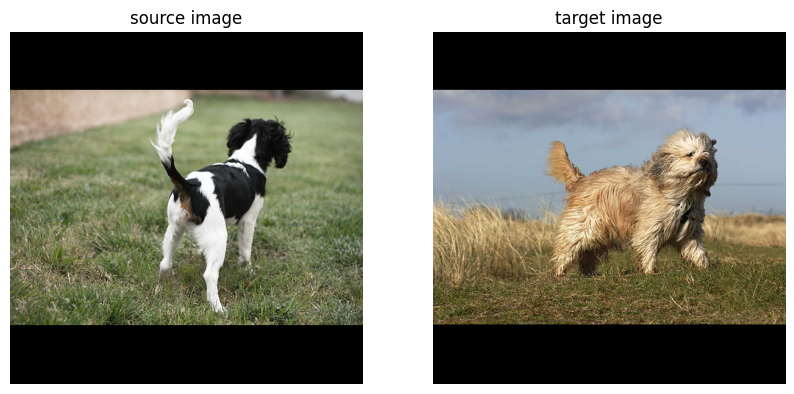

In [3]:
img_size = 480
img1_path = 'data/SPair-71k/JPEGImages/dog/2010_000899.jpg' # path to the source image
img1 = resize(Image.open(img1_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)

img2_path = 'data/SPair-71k/JPEGImages/dog/2011_002398.jpg' # path to the target image
img2 = resize(Image.open(img2_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)

# visualize the two images in the same row
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for a in ax: a.axis('off')
ax[0].imshow(img1)
ax[0].set_title('source image')
ax[1].imshow(img2)
ax[1].set_title('target image')
plt.show()

feat1 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img1, img_path=img1_path)
feat2 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img2, img_path=img2_path)

In [4]:
%matplotlib inline
from utils.utils_visualization_demo import Demo

demo = Demo([img1,img2], torch.cat([feat1, feat2], dim=0), img_size)
demo.plot_img_pairs(fig_size=5)

## Correspondence Demo for Your Own Image

In [5]:
img_size = 480
img1_path = 'data/images/unicorn.jpg' # path to the source image
img1 = resize(Image.open(img1_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)

img2_path = 'data/images/antelope.jpg' # path to the target image
img2 = resize(Image.open(img2_path).convert('RGB'), target_res=img_size, resize=True, to_pil=True)

# visualize the two images in the same row
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for a in ax: a.axis('off')
ax[0].imshow(img1)
ax[0].set_title('source image')
ax[1].imshow(img2)
ax[1].set_title('target image')
plt.show()

feat1 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img1)
feat2 = get_processed_features(sd_model, sd_aug, aggre_net, extractor_vit, num_patches, img=img2)

In [11]:
%matplotlib gtk3agg
%matplotlib widget
from utils.utils_visualization_demo import Demo

demo = Demo([img1,img2], torch.cat([feat1, feat2], dim=0), img_size)
demo.plot_img_pairs(fig_size=5)

KeyError: 'gtk3agg'

: 